In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sns
#!pip install rawpy
import rawpy

In [2]:
def load_image(file_path):
    raw = rawpy.imread(file_path)
    rgb = raw.postprocess()
    return rgb


In [3]:
DIR = "dataset_raw/"
image_diff = load_image(f"{DIR}filter_long_exp/IMG_8888.CR2")
image_org = load_image(f"{DIR}long_exp/IMG_8889.CR2")

print(image_diff.shape)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

(2856, 4290, 3)
cuda


In [186]:
import torch
import torch.nn.functional as F

def gaussian_kernel(sigma, k_size=3):
    """
    Generate Gaussian kernels for each pixel based on sigma values.

    Args:
        sigma (torch.Tensor): Sigma values with shape (B, C, H, W)
        k_size (int): Kernel size (default: 3)

    Returns:
        torch.Tensor: Gaussian kernels with shape (B, C, H, W, k_size, k_size)
    """
    device = sigma.device
    B, C, H, W = sigma.shape
    radius = k_size // 2

    # Create kernel grid
    y, x = torch.meshgrid(
        torch.arange(-radius, radius + 1, dtype=torch.float32, device=device),
        torch.arange(-radius, radius + 1, dtype=torch.float32, device=device),
        indexing='ij'
    )

    # Reshape for broadcasting
    x = x.view(1, 1, 1, 1, k_size, k_size)  # (1, 1, 1, 1, k, k)
    y = y.view(1, 1, 1, 1, k_size, k_size)
    sigma = sigma.unsqueeze(-1).unsqueeze(-1)  # (B, C, H, W, 1, 1)

    # Compute Gaussian weights
    coeff = 1.0 / (2 * torch.pi * sigma**2)
    exponent = -(x**2 + y**2) / (2 * sigma**2)
    weights = coeff * torch.exp(exponent)

    # Normalize kernels
    weights_sum = weights.sum(dim=(-2, -1), keepdim=True)
    weights = weights / weights_sum
    print(weights.shape)
    return weights

def adaptive_gaussian_conv2d(img, k_size=3):
    """
    Perform spatially adaptive Gaussian convolution.

    Args:
        img (torch.Tensor): Input image with shape (B, C, H, W)
        k_size (int): Kernel size (default: 3)

    Returns:
        torch.Tensor: Convolved output with shape (B, C, H, W)
    """
    img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
    B, C, H, W = img.shape

    #img[img>200] = img[img>200]*1.1
    #sigma = torch.where(img>200, 1, 10)
    
    img[img>250] = img[img>250]*1.1
    sigma = torch.where(img>250, 10, 0.001)


    # Generate Gaussian kernels
    kernels = gaussian_kernel(sigma, k_size).to(img.device)  # (B, C, H, W, k, k)
    print(kernels.shape)
    print(kernels[0, 0, 0, 0])

    # Unfold input image into patches
    pad = k_size // 2
    unfolded = F.unfold(img, kernel_size=k_size, padding=pad)  # (B, C*k*k, H*W)
    unfolded = unfolded.view(B, C, k_size*k_size, H, W)      # (B, C, k*k, H, W)
    unfolded = unfolded.permute(0, 1, 3, 4, 2)               # (B, C, H, W, k*k)

    # Reshape kernels and multiply with patches
    kernels_flat = kernels.view(B, C, H, W, -1)              # (B, C, H, W, k*k)
    output = (unfolded * kernels_flat).sum(dim=-1)           # (B, C, H, W)

    return output

In [187]:
torch.cuda.empty_cache()

In [188]:
torch.cuda.empty_cache()
blurred_image = adaptive_gaussian_conv2d(image_org[1200:2100, 1500:2400], k_size=29)[0].permute(1,2,0).cpu().numpy()
blurred_image = blurred_image / 255.0
print(blurred_image.min(), blurred_image.max())
#torch.cuda.empty_cache()

torch.Size([1, 3, 900, 900, 29, 29])
torch.Size([1, 3, 900, 900, 29, 29])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.

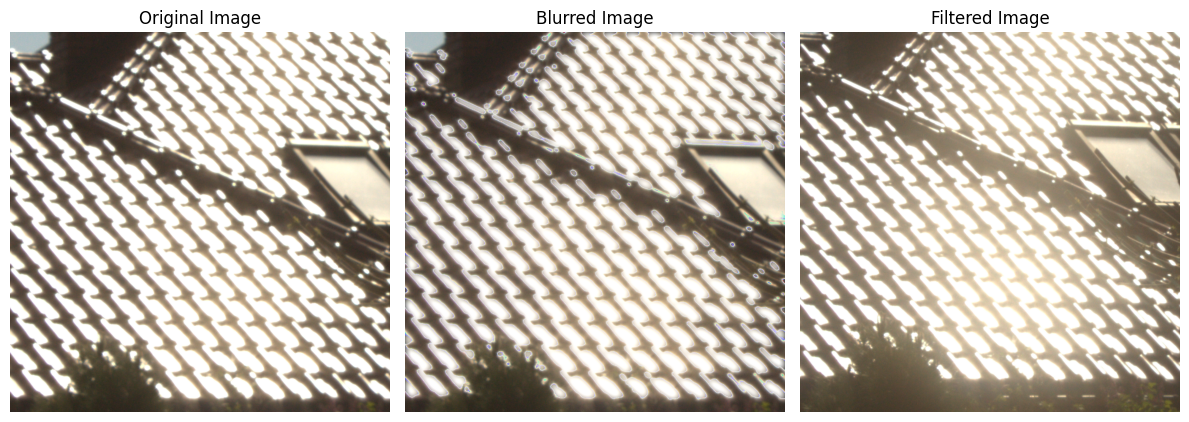

In [190]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(image_org[1200:2100, 1500:2400])
plt.title("Original Image")
plt.axis("off")


plt.subplot(1, 3, 2)
plt.imshow(np.clip(blurred_image, 0, 1))
plt.title("Blurred Image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(image_diff[1200:2100, 1500:2400])
plt.title("Filtered Image")
plt.axis("off")


plt.tight_layout()
plt.show()

array([[-0.45930714, -0.44576218, -0.43385379, ...,  0.09963119,
         0.09961677,  0.09539891],
       [-0.4340123 , -0.39268691, -0.38069553, ...,  0.10000002,
         0.10000002,  0.09961677],
       [-0.40249   , -0.35324056, -0.32571811, ...,  0.10000002,
         0.10000002,  0.09963131],
       ...,
       [-0.11154667, -0.10478732, -0.08680385, ..., -0.09374714,
        -0.10436929, -0.11561484],
       [-0.13551137, -0.10250441, -0.08173503, ..., -0.10427902,
        -0.10594387, -0.1160025 ],
       [-0.12451301, -0.10844709, -0.0927855 , ..., -0.12328645,
        -0.11984256, -0.12471674]])

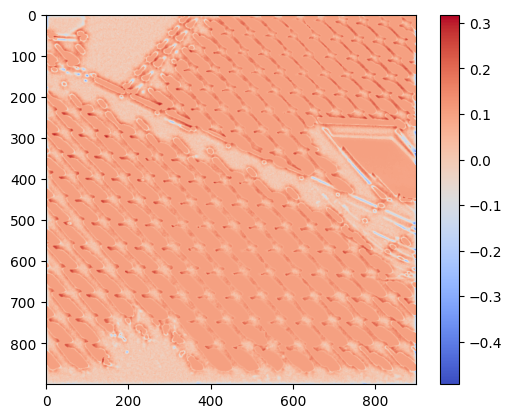

In [122]:
diff = ((blurred_image - image_org[1200:2100, 1500:2400] / 255.0)[:, :, 0])
plt.imshow(diff, cmap="coolwarm")
plt.colorbar()
diff